In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [12]:
pip install jieba gensim

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


不同用户类型的影响范围和影响程度

In [4]:
# 读取Excel文件
data = pd.read_excel(r"H:\data2.xlsx")

In [20]:
# Descriptive Statistics for relevant columns
descriptive_stats = data[['followers_count', '转发数', '评论数', '点赞数']].describe()

# User Type Analysis
user_type_counts = data['user_class'].value_counts()

# Preparing for Time Series Analysis
# Converting the '发布时间' column to datetime format and setting it as index for time series analysis
data['发布时间'] = pd.to_datetime(data['发布时间'])
data.set_index('发布时间', inplace=True)

# Time Series Analysis - Aggregating data on a daily basis
daily_activity = data.resample('D').agg({'转发数': 'sum', '评论数': 'sum', '点赞数': 'sum'})

descriptive_stats, user_type_counts, daily_activity.head()


(       followers_count           转发数           评论数            点赞数
 count     9.667000e+03   9667.000000   9667.000000    9667.000000
 mean      1.971038e+06      5.999276      7.997414      62.182580
 std       9.656518e+06    122.452809    131.232542    1447.941293
 min       0.000000e+00      0.000000      0.000000       0.000000
 25%       2.640000e+02      0.000000      0.000000       0.000000
 50%       1.923100e+04      0.000000      0.000000       1.000000
 75%       5.565110e+05      0.000000      2.000000       4.000000
 max       1.528197e+08  10021.000000  10023.000000  101211.000000,
 0    4628
 7    1455
 2    1148
 5    1024
 3     598
 4     424
 6     302
 1      88
 Name: user_class, dtype: int64,
               转发数    评论数     点赞数
 发布时间                            
 2023-07-29  20268  29222  222822
 2023-07-30  13711  17199  129794
 2023-07-31   4448   4412   23466
 2023-08-01   8208  15444  135933
 2023-08-02  11360  11034   89104)

In [5]:
import pandas as pd
import numpy as np

# 读取Excel文件
data = pd.read_excel(r"H:\data2.xlsx")
# 最大-最小标准化
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min()) * 100
# Z 分数标准化
def z_score_scaling(series):
    return (series - series.mean()) / series.std()

# 对数转换后再进行最大-最小标准化
def log_min_max_scaling(series):
    return (np.log1p(series) - np.log1p(series).min()) / (np.log1p(series).max() - np.log1p(series).min()) * 100

def calculate_influence_scores(data):
    weights = {
        'Quality': 0.5,
        'Top': 0.5,
        'Comments': 1/3,
        'Reposts1': 1/3,
        'Likes': 1/3,
        'Fans': 0.5,
        'Reposts2': 0.5,
        'Activity': 1/3,
        'Spread': 1/3,
        'Coverage': 1/3
    }

    # Calculating raw scores
    data['活跃度'] = (min_max_scaling(data['high_quality']) * weights['Quality'] +
                            min_max_scaling(data['top_user']) * weights['Top'])

    data['传播力'] = (log_min_max_scaling(data['转发数']) * weights['Reposts1'] +
                      log_min_max_scaling(data['评论数']) * weights['Comments']+
                          log_min_max_scaling(data['点赞数']) * weights['Likes'])

    data['覆盖度'] = (log_min_max_scaling(data['粉丝量']) * weights['Fans'] +
                            log_min_max_scaling(data['转发数']) * weights['Reposts2'])
    

    # Calculating overall influence score
    data['综合影响力'] = (data['活跃度'] * weights['Activity'] +
                               data['传播力'] * weights['Spread'] +
                               data['覆盖度'] * weights['Coverage'])

    return data

def calculate_user_type_stats(data):
    # 计算每个用户类型的综合影响力的最大值、最小值和平均值
    user_type_stats = data.groupby('用户类型')['综合影响力'].agg(['max', 'min', 'mean'])
    return user_type_stats

# Calculate influence scores
influence_scores = calculate_influence_scores(data)

# Display the results
# print(influence_scores[['活跃度', '传播力', '覆盖度', '综合影响力']])
data['综合影响力'].min()

# 执行函数并打印结果
user_type_stats = calculate_user_type_stats(influence_scores)
print(user_type_stats)

            max        min       mean
用户类型                                 
0.0   48.485716   0.000000   6.576464
1.0   58.424279  27.185256  35.476060
2.0   41.036731   2.604117  10.583013
3.0   57.629869  27.119309  33.947282
4.0   64.000971  24.465767  29.108093
5.0   95.984123  43.574261  52.383490
6.0   79.271757  25.070514  28.388763
7.0   89.783724  43.813491  50.829325


互动量预测模型

In [ ]:
# 清理缺失值（假设'互动区间'是您的目标变量）
data_clean = data.dropna(subset=['粉丝量', 'top_user', 'high_quality', 'official', 'verified', '图片数量', '视频数量'])
# 定义区间边界和标签
bins = [0, 50, 500, 5000, float('inf')]
labels = ['低', '中', '高', '非常高']
data['互动区间'] = pd.cut(data['互动数'], bins=bins, labels=labels, include_lowest=True)

# 选择特征和目标变量
features = data[['粉丝量', 'top_user', 'high_quality', 'official', 'verified', '图片数量', '视频数量']]
target = data['互动区间']

# 数据预处理：标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# 检查标准化后的特征是否有NaN值
if np.isnan(features_scaled).any():
    raise ValueError("特征标准化后存在缺失值。")

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
# 检查分割后的数据是否有NaN值
if np.isnan(X_train).any() or np.isnan(X_test).any():
    raise ValueError("分割数据后存在缺失值。")
# 构建决策树模型
model = DecisionTreeClassifier(random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
predictions = model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, predictions)
print(f"准确率: {accuracy}")
print("\n分类报告：")
print(classification_report(y_test, predictions))

其他分析

In [8]:
import pandas as pd
import numpy as np
import jieba
from gensim.models import Word2Vec

# 加载停用词
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = set([line.strip() for line in file.readlines()])
    return stopwords

# 合并多个停用词表
stopwords_files = [
    r"H:\stopwords-master\stopwords-master\baidu_stopwords.txt",
    r"H:\stopwords-master\stopwords-master\cn_stopwords.txt",
    r"H:\stopwords-master\stopwords-master\hit_stopwords.txt",
    r"H:\stopwords-master\stopwords-master\scu_stopwords.txt"
]
combined_stopwords = set()
for file in stopwords_files:
    combined_stopwords = combined_stopwords.union(load_stopwords(file))

# 分词并去除停用词
def preprocess_text(text, stopwords):
    words = jieba.cut(text)
    return [word for word in words if word not in stopwords and not word.isspace()]

# 假设 'data' 是包含微博正文的 DataFrame
# data = pd.read_excel('path_to_your_data.xlsx')
# 确保所有的文本都是字符串类型
data['微博正文'] = data['微博正文'].astype(str)
# 对微博正文进行分词和去停用词处理
data['processed_text'] = data['微博正文'].apply(lambda x: preprocess_text(x, combined_stopwords))

# 使用 Word2Vec 模型
model = Word2Vec(data['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# 获取特征向量示例（针对一个词）
# word_vector = model.wv['示例词']

# 如果需要获取整个文本的特征向量，可以通过平均词向量的方式获取
def document_vector(doc, model):
    # 删除文档中不在词汇表中的词
    doc = [word for word in doc if word in model.wv.key_to_index]
    if len(doc) == 0:
        return []
    # 返回词向量的平均值
    return np.mean(model.wv[doc], axis=0)

# 应用到所有文档
data['doc_vector'] = data['processed_text'].apply(lambda x: document_vector(x, model))


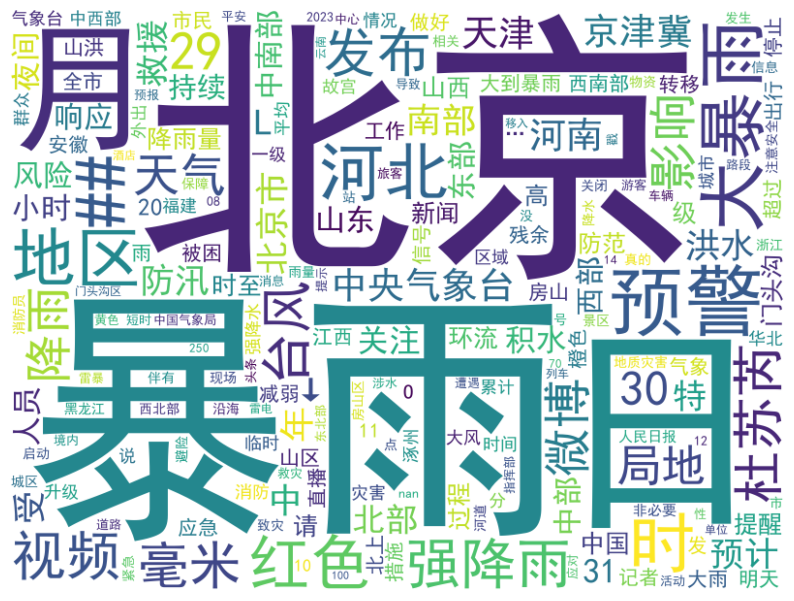

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 合并所有分词后的列表到一个大的列表中
all_words = sum(data['processed_text'].tolist(), [])

# 计算词频
word_freq = Counter(all_words)

# 生成词云图
wordcloud = WordCloud(font_path='simhei.ttf',  # 设置字体（这里使用黑体，您可能需要更改为适合您系统的字体路径）
                      background_color='white', 
                      width=800, 
                      height=600).generate_from_frequencies(word_freq)

# 显示词云图
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# 获取前20个最常见的词及其频率
top_20_words = word_freq.most_common(20)

# 创建 DataFrame 来展示这些词及其频率
top_words_df = pd.DataFrame(top_20_words, columns=['关键词', '词频'])

top_words_df

,关键词,词频
0,北京,16818
1,暴雨,15198
2,日,8833
3,月,7033
4,预警,6019
5,##,5349
6,大暴雨,4886
7,时,4161
8,河北,4043
9,地区,3984


In [25]:
data['processed_text']

0        [天气预报, 市, 气象台, 29, 日, 时, 发布, 白天, 多云转阴, 雷阵雨, 北转...
1        [中央气象台, 月, 29, 日, 06, 时, 发布, 台风, 蓝色, 预警, 号, 台风...
2        [早安, 北京, ｜, 月, 29, 日, 白天, 多云转阴, 雷阵雨, 夜间, 月, 日有...
3        [最新, 天气预报, 29, 日, 07, 时, 发布, 预计, 29, 日, 白天, 本市...
4        [北京, 强降雨, 真的, 要来, ##, 最新, 天气预报, 29, 日, 07, 时, ...
                               ...                        
10179                                                [nan]
10180                                                [nan]
10181                                                [nan]
10182                                                [nan]
10183                                                [nan]
Name: processed_text, Length: 10184, dtype: object

In [10]:
df = pd.DataFrame(data['processed_text'], columns=['Processed Text'])

# 导出到Excel文件
df.to_excel(r"H:\processed.xlsx", index=False)
